In [1]:
import os
import random
from multiprocessing import cpu_count

import matplotlib.pyplot as plt
import numpy as np
import PIL
import torch
import torch.nn.functional as F
import wandb
from dataset.affectnet import AffectNetDataset
from dataset.facialexpressions import FacialExpressionsDataset
from dataset.ferplus import FERPlusDataset
from dataset.rafdb import RAFDataset
from imgaug import augmenters as iaa
from layer.mish import MemoryEfficientMish, Mish
from layer.rademacher_dropout import RademacherDropout
from mish_cuda import MishCuda
from model.ab import AccuracyBoosterPlusBlock
from model.resnet import custom_resnet18, custom_resnet34, custom_resnet50
from model.se import SqueezeExcitationBlock
from optim.lookahead import Lookahead
from optim.radam import RAdam
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import LabelBinarizer
from torch import nn, optim
from torch.utils.data import ConcatDataset, DataLoader, Dataset, random_split
from torchvision import models, transforms
from tqdm.auto import tqdm, trange
from trainer import Trainer

In [2]:
torch.multiprocessing.set_sharing_strategy("file_system")
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
torch.manual_seed(42)
np.random.seed(42)
random.seed(42)

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [4]:
resize_transform = transforms.Resize(224)
centercrop_transform = transforms.CenterCrop(224)
tensor_transform = transforms.ToTensor()
normalize_transform = transforms.Normalize(
    mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]
)


class ImgAugTransform:
    def __init__(self):
        self.aug = iaa.Sequential(
            [
                iaa.GaussianBlur(sigma=(0.25, 2.5)),
                iaa.Affine(rotate=(-20, 20), mode="symmetric"),
            ]
        )

    def __call__(self, img):
        img = np.array(img)
        return self.aug.augment_image(img)


train_transform = transforms.Compose(
    [
        resize_transform,
        centercrop_transform,
        transforms.RandomHorizontalFlip(),
        transforms.ColorJitter(
            brightness=0.25, contrast=0.25, hue=0.05, saturation=0.05
        ),
        ImgAugTransform(),
        tensor_transform,
        normalize_transform,
    ]
)
predict_transform = transforms.Compose(
    [resize_transform, centercrop_transform, tensor_transform, normalize_transform]
)

In [5]:
trainset = ConcatDataset(
    [
        AffectNetDataset("../dataset/AffectNet", "train", transform=train_transform),
        FacialExpressionsDataset(
            "../dataset/facial_expressions", transform=train_transform
        ),
        FERPlusDataset("../dataset/FERPlus", "train", transform=train_transform),
        RAFDataset("../dataset/RAF-DB", "train", transform=train_transform),
    ]
)
len(trainset)

342497

In [6]:
trainloader = DataLoader(
    trainset, batch_size=32, shuffle=True, num_workers=cpu_count(), drop_last=True
)
trainloader_not_shuffled = DataLoader(
    trainset, batch_size=32, shuffle=False, num_workers=cpu_count(), drop_last=True
)

In [7]:
classes = [
    "neutral",
    "happy",
    "surprise",
    "sad",
    "anger",
    "disgust",
    "fear",
    "contempt",
]
classes

['neutral', 'happy', 'surprise', 'sad', 'anger', 'disgust', 'fear', 'contempt']

In [8]:
n_samples = np.zeros(len(classes), dtype=int)

for innerset in trainset.datasets:
    for label in innerset.get_labels():
        n_samples[label] += 1

n_samples

array([ 94645, 152606,  19305,  31289,  28417,   4919,   7389,   3927])

In [9]:
normed_weights = [1 - (x / sum(n_samples)) for x in n_samples]
normed_weights = torch.FloatTensor(normed_weights).to(device)
normed_weights

tensor([0.7237, 0.5544, 0.9436, 0.9086, 0.9170, 0.9856, 0.9784, 0.9885],
       device='cuda:0')

<ipython-input-10-6e23455d9a69>:3: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  img = np.vstack(


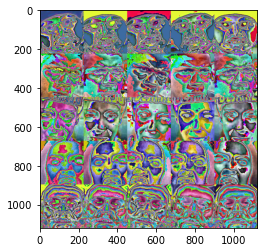

In [10]:
def show_dataset(dataset, n=5):
    pil_transform = transforms.ToPILImage()
    img = np.vstack(
        np.hstack([pil_transform(dataset[i][0]) for _ in range(5)])
        for i in [random.randint(0, len(dataset)) for _ in range(n)]
    )
    plt.imshow(img)


show_dataset(trainset)

In [11]:
valtestset = ConcatDataset(
    [
        AffectNetDataset("../dataset/AffectNet", "val", transform=predict_transform),
        FERPlusDataset("../dataset/FERPlus", "val", transform=predict_transform),
        FERPlusDataset("../dataset/FERPlus", "test", transform=predict_transform),
        RAFDataset("../dataset/RAF-DB", "test", transform=predict_transform),
    ]
)
valsize = int(len(valtestset) / 2)
valset, testset = random_split(valtestset, [valsize, int(len(valtestset) - valsize)])

valloader = DataLoader(valset, batch_size=16, shuffle=False, num_workers=cpu_count())
testloader = DataLoader(testset, batch_size=16, shuffle=False, num_workers=cpu_count())
len(valset), len(testset)

(7084, 7084)

In [12]:
# final_model = models.resnet18(pretrained=True)
# final_model = torch.hub.load("moskomule/senet.pytorch", "se_resnet50", pretrained=True)
# final_model.fc = nn.Linear(final_model.fc.in_features, len(classes))

In [13]:
final_model = custom_resnet18(
    activation_layer=MishCuda(),
    network_type="pyramid",
    output_block={"class": AccuracyBoosterPlusBlock, "params": {}},
    num_classes=len(classes),
)

In [14]:
final_model = final_model.to(device)
final_model

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (activation_layer): MishCuda()
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (activation_layer): MishCuda()
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (bn3): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (output_block): AccuracyBoosterPlusBlock(
        (pooling_layer): AdaptiveAvgPool2d(output_size=1)
        (mid_conn): Sequential(
         

In [15]:
criterion = nn.CrossEntropyLoss(weight=normed_weights)

In [16]:
trainer = Trainer(
    "facial-expressions-essay",
    final_model,
    device,
    trainloader,
    classes,
    criterion,
    valloader=valloader,
    optimizer=Lookahead(RAdam(final_model.parameters(), lr=1e-3)),
    #     optimizer_params={"lr": 1e-3, "momentum": 0.9},
    gradient_accumulation=8,
    lr_find=False,
    lr_finder_params={
        "start_lr": 1e-8,
        "end_lr": 1,
        "num_iter": 1000,
        "step_mode": "linear",
    },
    max_step=5_000,
)

RAdam optimizer loaded. 
Gradient Centralization usage = True 
Diffgrad usage = True
GC applied to both conv and fc layers


wandb: Currently logged in as: yusufrahadika (use `wandb login --relogin` to force relogin)


None


In [17]:
trainer.train()

/run/media/yusufrahadika/WORKSPACE/facial-expressions-essay/facial-expressions/optim/radam.py:90: UserWarning: This overload of add_ is deprecated:
	add_(Number alpha, Tensor other)
Consider using one of the following signatures instead:
	add_(Tensor other, *, Number alpha) (Triggered internally at  /opt/conda/conda-bld/pytorch_1603729062494/work/torch/csrc/utils/python_arg_parser.cpp:882.)
  exp_avg.mul_(beta1).add_(1 - beta1, grad)



Training completed


In [18]:
def predict(model, dataloader, device):
    model.eval()
    y_pred = []
    for i, (inputs, _) in enumerate(dataloader):
        inputs = inputs.to(device)
        outputs = model(inputs)
        _, predicted = torch.max(outputs, 1)
        y_pred.append(predicted)

    return torch.cat(y_pred).cpu().numpy()

In [19]:
%%timeit
y_test_pred = predict(final_model, testloader, device)

7 s ± 44.8 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [20]:
y_test_actual = np.asarray([target for _, targets in testloader for target in targets])
y_test_pred = predict(final_model, testloader, device)

In [21]:
"Test accuracy:", accuracy_score(y_test_actual, y_test_pred)

('Test accuracy:', 0.6962168266516092)